In [ ]:
## running nsl 
https://github.com/szpiech/selscan/blob/main/Selscan_Manual_v2_1.pdf

In [2]:
import allel
import numpy as np
import pandas as pd

python(81412) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [179]:
## first im going to do some checkigno n how sparse the snps are

callset = allel.read_vcf('modern_imputed.vcf.gz', fields=['variants/CHROM', 'variants/POS'])

In [184]:
## checkinghte sopacing across snps as a quality check 
chroms = callset['variants/CHROM']
positions = callset['variants/POS']
df = pd.DataFrame({'chrom': chroms, 'pos': positions})
spacing_results = []

for chrom, group in df.groupby('chrom'):
    pos = group['pos'].values
    gaps = np.diff(pos)
    avg_gap = gaps.mean() if len(gaps) > 0 else np.nan
    spacing_results.append({
        'chrom': chrom,
        'num_snps': len(pos),
        'avg_spacing_bp': avg_gap
    })

genome_avg = spacing_df['avg_spacing_bp'].mean()
genome_avg

Genome-wide average SNP spacing: 82.25 bp


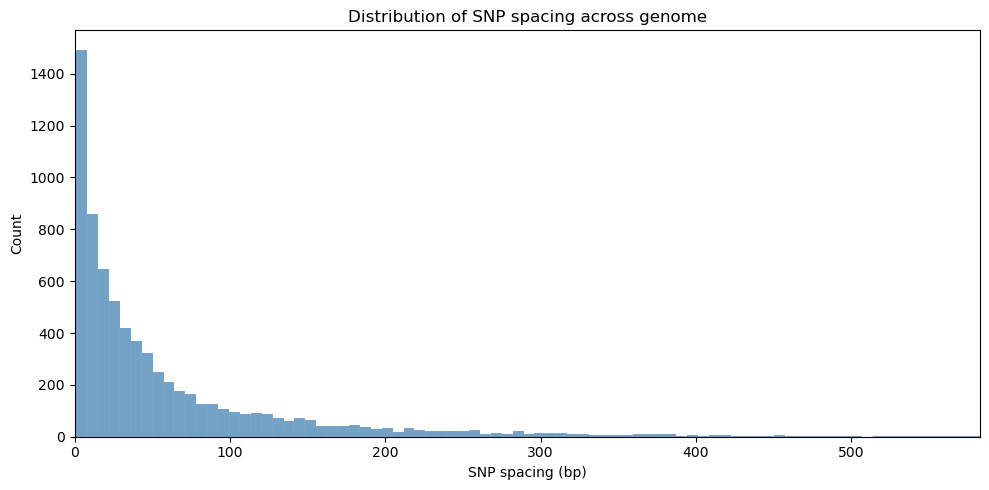

In [205]:
# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(pd.Series(gaps).sample(frac=0.005).reset_index()[0], kde=False, color='steelblue', edgecolor='white')
plt.xlabel('SNP spacing (bp)')
plt.ylabel('Count')
plt.title('Distribution of SNP spacing across genome')
plt.xlim(0, np.percentile(gaps, 99))  # Limit to 99th percentile for clarity
plt.tight_layout()
plt.show()

In [ ]:
### for usign selscan we need to make sure:

- the vcf file is phased
- there is no missing genotype

bcftools view -g ^miss -m2 -M2 -v snps \
  modern_shared_paired_samples_filtered_biallelic.vcf.gz \
  -Oz -o modern_shared_paired_samples_filtered_biallelic_selscan.vcf.gz

- selscan runs poer chroomosmes so we will need to cut the vcf file into chroomosoems

for CHR in {1..5}; do
  echo "Extracting chromosome $CHR..."
  bcftools view -r $CHR modern_selscan_with_ids.vcf.gz -Oz -o modern_chr${CHR}.vcf.gz
  bcftools index modern_chr${CHR}.vcf.gz
done

# one run 
selscan --nsl \
    --vcf chr1_wmiss.vcf.gz \
    --out selscan_chr1_wmiss_nsl \
    --threads 2


## after running selscan we need to normalize the results 




To get rid of missing genotypes im goiung to use beagle to iunpute missing sites, based on the vcf file from which I already filtered for sites with more than 10%missing

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re

In [46]:
## inpute vcf file 

import subprocess

# Define paths and filenames
vcf_file = "modern_shared_paired_samples_filtered_biallelic.vcf.gz"
output_prefix = "modern_imputed"
beagle_jar_path = "/home/tbellagio/scratch/selection_scan/selection_scan/beagle.jar"  # Replace with actual path
sbatch_path = "/home/tbellagio/scratch/selection_scan/selection_scan"  # Replace with actual path
job_index = 1 

sbatch_command = f"""#!/bin/bash
#SBATCH --job-name="beagle_{job_index}"
#SBATCH --time=48:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=4
#SBATCH --mem=16G
#SBATCH --output={sbatch_path}/beagle_{job_index}_output.txt
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

java -Xmx16g -jar {beagle_jar_path} \\
  gt={vcf_file} \\
  out={output_prefix} \\
  impute=true \\
  nthreads=2
"""

sbatch_file = f"sbatch_beagle_{job_index}.sh"
with open(sbatch_file, 'w') as file:
    file.write(sbatch_command)

subprocess.run(['sbatch', sbatch_file])


Submitted batch job 68179


CompletedProcess(args=['sbatch', 'sbatch_beagle_1.sh'], returncode=0)

In [ ]:
## this didnt retunr anything, menaing htat the vcf file has bee nfully inputed 
bcftools query -f '[%GT]\n' modern_imputed.vcf.gz | \
awk '{for (i=1; i<=NF; i++) if ($i ~ /\./) {count++; break}} END {print count}'


In [ ]:
## so now again, separate the chromosmes and run selscan 

In [ ]:
for CHR in {1..5}; do
  echo "Extracting chromosome $CHR..."
  bcftools view -r $CHR modern_imputed.vcf.gz -Oz -o modern_chr${CHR}.vcf.gz
  bcftools index modern_chr${CHR}.vcf.gz
done

In [9]:
import subprocess
import datetime

# Path where SLURM logs and scripts go
sbatch_path = "/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan"
batch_script_list = []

# Optional: Add timestamp to avoid collisions when re-running
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

for chr_num in range(1, 6):
    sbatch_filename = f"sbatch_selscan_chr{chr_num}_{timestamp}.sh"
    log_filename = f"{sbatch_path}/selscan_chr{chr_num}_{timestamp}_output.txt"

    sbatch_command = f"""#!/bin/bash
#SBATCH --job-name="selscan_chr{chr_num}"
#SBATCH --time=4:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=4
#SBATCH --mem=8G
#SBATCH --output={log_filename}
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

cd /carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan
pwd
source /home/tbellagio/miniforge3/etc/profile.d/conda.sh
conda activate /home/tbellagio/miniforge3/envs/gwas

echo "Running selscan on chromosome {chr_num}..."

selscan --nsl \\
  --vcf modern_chr{chr_num}.vcf.gz \\
  --out selscan_chr_maf01_{chr_num}_nsl \\
  --maf 0.01 \\
  --threads 4
"""

    # Save batch script
    with open(sbatch_filename, 'w') as f:
        f.write(sbatch_command)

    # Track it
    batch_script_list.append(sbatch_filename)



In [10]:
batch_script_list[1]

'sbatch_selscan_chr2_20250719_154522.sh'

In [11]:
for i in range(len(batch_script_list)):
    subprocess.run(['sbatch', batch_script_list[i]])

Submitted batch job 68504
Submitted batch job 68505
Submitted batch job 68506
Submitted batch job 68507
Submitted batch job 68508


In [ ]:
## nsl 

In [3]:
import glob

In [4]:
nsl_files = sorted(glob.glob("selscan_chr_maf01_*_nsl.nsl.out"))

In [13]:
nsl_files

['selscan_chr_maf01_1_nsl.nsl.out',
 'selscan_chr_maf01_2_nsl.nsl.out',
 'selscan_chr_maf01_3_nsl.nsl.out',
 'selscan_chr_maf01_4_nsl.nsl.out',
 'selscan_chr_maf01_5_nsl.nsl.out']

In [ ]:
## normlaize 
norm --nsl \
  --bins 1000 \
  --files selscan_chr_maf01_*_nsl.nsl.out

In [5]:
nsl_files = sorted(glob.glob("*_nsl.nsl.out.1000bins.norm"))

In [6]:
nsl_files

['selscan_chr_maf01_1_nsl.nsl.out.1000bins.norm',
 'selscan_chr_maf01_2_nsl.nsl.out.1000bins.norm',
 'selscan_chr_maf01_3_nsl.nsl.out.1000bins.norm',
 'selscan_chr_maf01_4_nsl.nsl.out.1000bins.norm',
 'selscan_chr_maf01_5_nsl.nsl.out.1000bins.norm']

In [27]:
import pandas as pd
import glob
import re

# Find all normalized nSL files
#selscan_chr_maf01_*_nsl.nsl.out.100bins
dfs = []
for file in nsl_files:
    chr_num = file.split('_')[3]
    # Extract chromosome number using regex
    #chr_num = int(re.search(r"chr(\d+)", file).group(1))
    
    # Load file with appropriate column names
    df = pd.read_csv(file , delim_whitespace=True, header=None,
                 names=["snp_id", "pos", "freq", "sl1", "sl0", "raw_nsl", "norm_nsl", "flag"])
    df["chrom"] = f"{chr_num}"
    df["chrom_numeric"] = chr_num
    dfs.append(df)

# Concatenate all chromosomes into one DataFrame
nsl_all = pd.concat(dfs, ignore_index=True)

In [28]:
nsl_all

,snp_id,pos,freq,sl1,sl0,raw_nsl,norm_nsl,flag,chrom,chrom_numeric
0,.,12584,0.555556,36.5294,104.4960,-1.051030,-1.753570,0,1,1
1,.,12947,0.206349,137.5040,43.3547,1.154240,1.151080,0,1,1
2,.,13260,0.412698,49.3143,72.0236,-0.378780,-1.031030,0,1,1
3,.,13538,0.423280,47.2742,74.7794,-0.458578,-1.032480,0,1,1
4,.,13797,0.010582,183.6670,37.3449,1.592930,0.628870,0,1,1
...,...,...,...,...,...,...,...,...,...,...
1082223,.,26780507,0.037037,54.0440,48.5634,0.106927,-1.747170,0,5,5
1082224,.,26780582,0.026455,193.4220,47.7861,1.398140,0.484864,0,5,5
1082225,.,26780677,0.031746,141.8180,48.8172,1.066460,-0.061468,0,5,5
1082226,.,26780689,0.677249,42.0608,195.9410,-1.538700,-2.031850,1,5,5


In [29]:
# Sort by chromosome and position
nsl_all = nsl_all.sort_values(["chrom_numeric", "pos"])

# Compute cumulative basepair position for plotting
chrom_offsets = nsl_all.groupby("chrom_numeric")["pos"].max().cumsum().shift(fill_value=0)
nsl_all["pos_cum"] = nsl_all.apply(lambda  row: row["pos"] + chrom_offsets[row["chrom_numeric"]], axis=1)

In [30]:
#nsl_all.to_csv('nsl_all_maf01.csv',index=None)

In [3]:
nsl_all = pd.read_csv('nsl_all_maf01.csv')

In [4]:
nsl_all['chrom'] = nsl_all['chrom'].astype(int)

In [5]:
df = nsl_all.copy()

In [6]:
import matplotlib.pyplot as plt

In [7]:
gene_df = pd.read_csv('../genes_df.csv')

/var/folders/89/m0n7cpqn6153r2j98t2n5yq40000gr/T/ipykernel_81353/2798150815.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/tatiana/mambaforge/envs/simulations/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


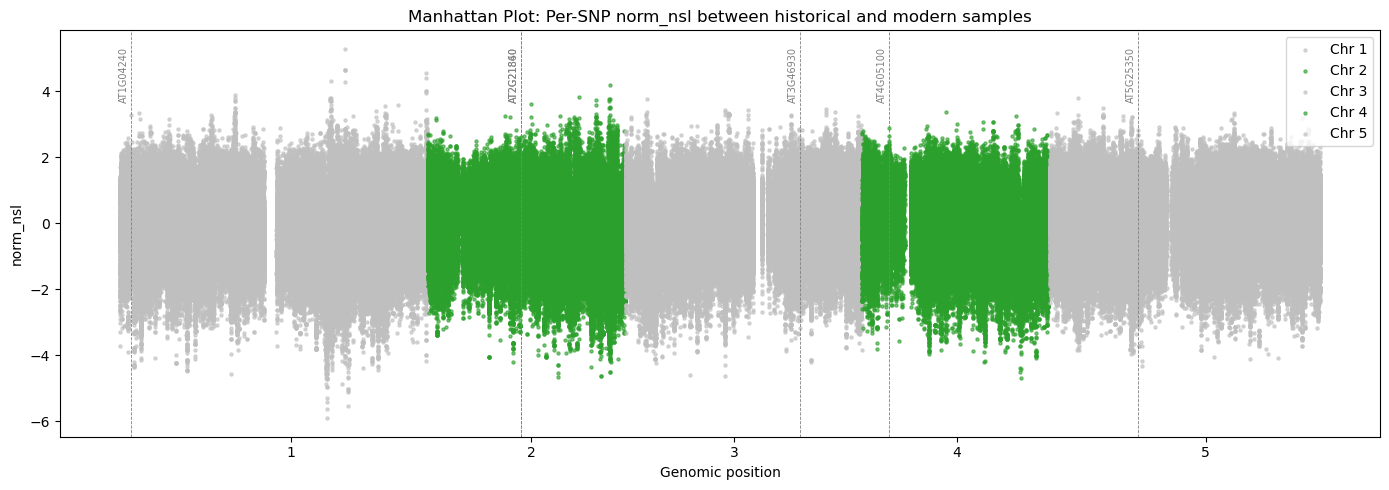

In [8]:
plt.figure(figsize=(14, 5))
colors = ['#bfbfbf', '#2ca02c']

for i, (chrom, group) in enumerate(df.groupby('chrom')):
    plt.scatter(group['pos_cum'], group['norm_nsl'], s=5, alpha=0.6, color=colors[i % 2], label=f'Chr {group.chrom.iloc[0]}')
plt.legend().remove() 


# Chromosome ticks
xticks = df.groupby('chrom')['pos_cum'].median()
xtick_labels = df.groupby('chrom')['chrom'].first()

plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlabel('Genomic position')
plt.ylabel('norm_nsl')
plt.title('Manhattan Plot: Per-SNP norm_nsl between historical and modern samples')
plt.legend()
plt.tight_layout()

for _, row in gene_df.iterrows():
    chrom = row['chrom']
    gene_start = row['start']
    gene_ends = row['end']
    gene_id = row['gene_id']

    # Compute gene center
    gene_center = (gene_start + gene_ends) // 2

    # Subset df by chromosome
    subset = df[df['chrom'] == chrom]

    # Find the nearest position to the gene center
    nearest_idx = (subset['pos'] - gene_center).abs().idxmin()
    gene_pos_cum = subset.loc[nearest_idx, 'pos_cum']

    # Plot vertical line at gene
    plt.axvline(gene_pos_cum, color='grey', linestyle='--', linewidth=0.6)

    # Add gene label
    plt.text(gene_pos_cum - 7e5, df['norm_nsl'].max() * 0.7, gene_id,
             rotation=90, fontsize=7, color='grey', ha='center')

plt.show()

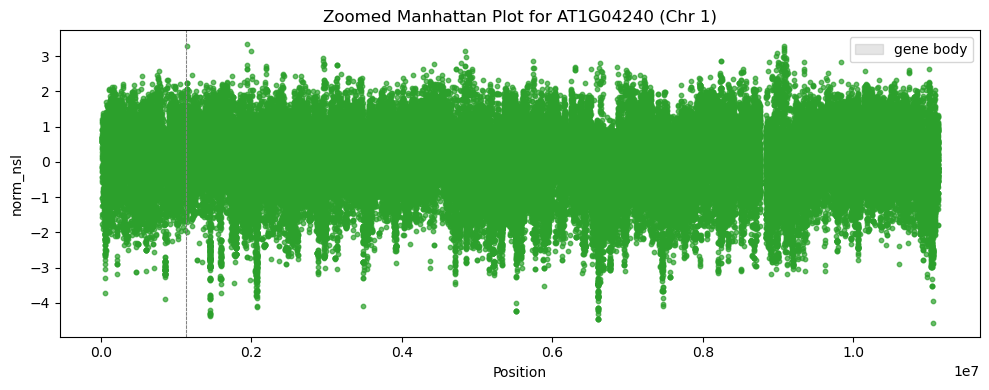

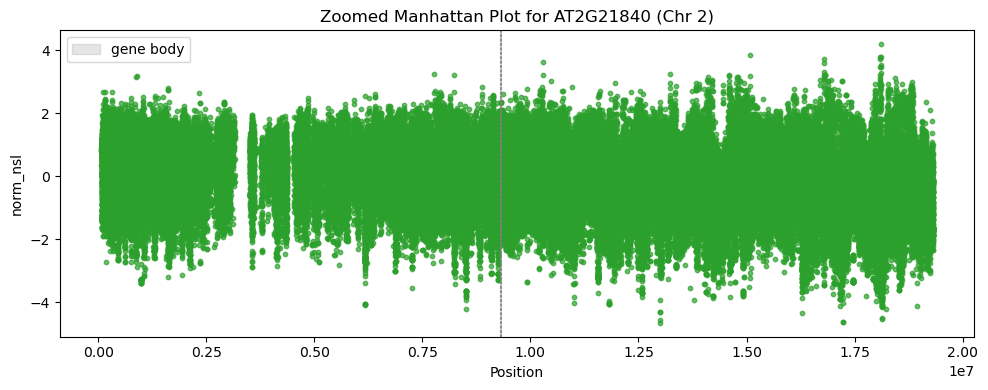

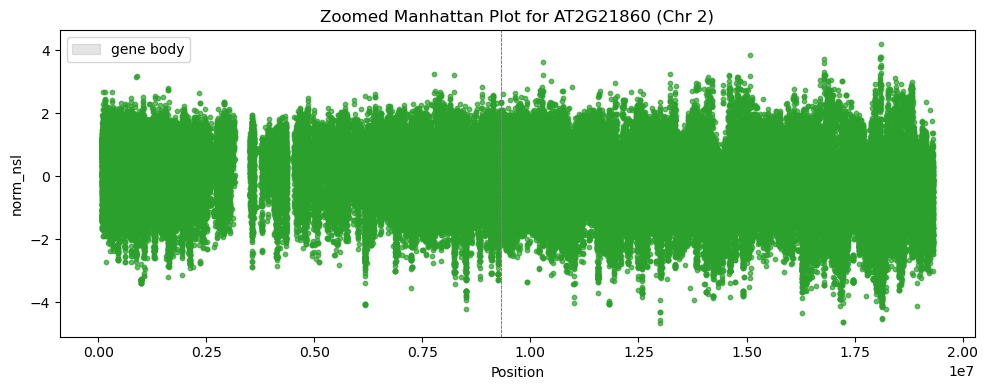

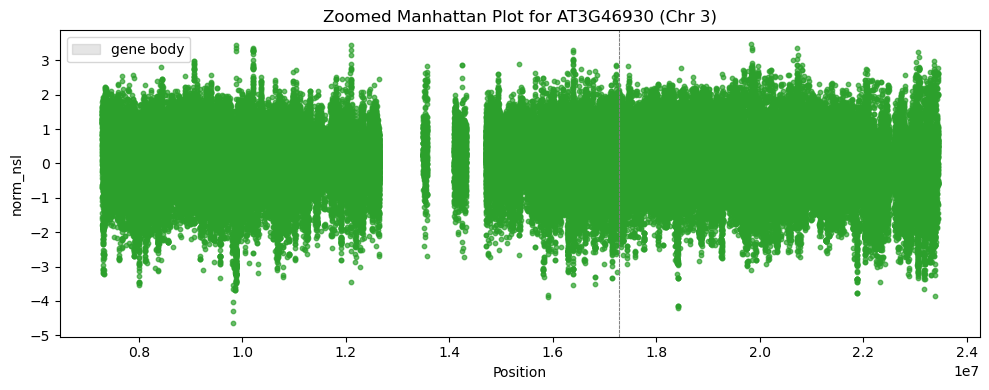

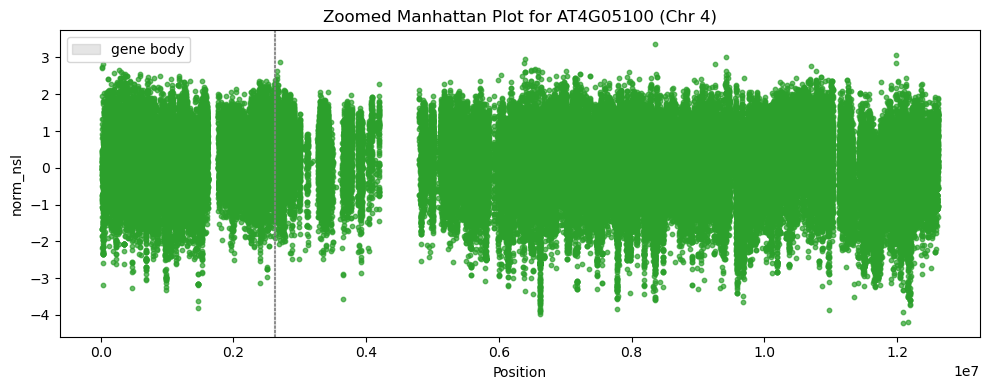

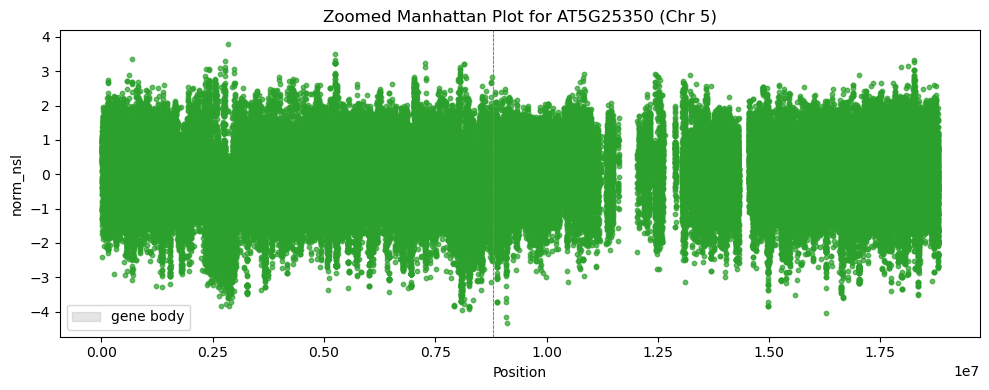

In [9]:
import matplotlib.pyplot as plt

for _, row in gene_df.iterrows():
    chrom = row['chrom']
    gene_start = row['start']
    gene_end = row['end']
    gene_id = row['gene_id']
    
    # Filter region: ±5kb around gene
    region_df = df[(df['chrom'] == chrom) & (df['pos'] >= gene_start - 10000000) & (df['pos'] <= gene_end + 10000000)]

    if region_df.empty:
        continue  # Skip if no data in region

    plt.figure(figsize=(10, 4))

    # Manhattan-style scatter
    plt.scatter(region_df['pos'], region_df['norm_nsl'], s=10, alpha=0.7, color='#2ca02c')
    
    # Gene region highlight
    plt.axvspan(gene_start, gene_end, color='grey', alpha=0.2, label='gene body')
    plt.axvline(gene_start, color='grey', linestyle='--', linewidth=0.6)
    plt.axvline(gene_end, color='grey', linestyle='--', linewidth=0.6)

    # Plot labels
    plt.title(f'Zoomed Manhattan Plot for {gene_id} (Chr {chrom})')
    plt.xlabel('Position')
    plt.ylabel('norm_nsl')
    plt.legend()
    plt.tight_layout()
    plt.show()


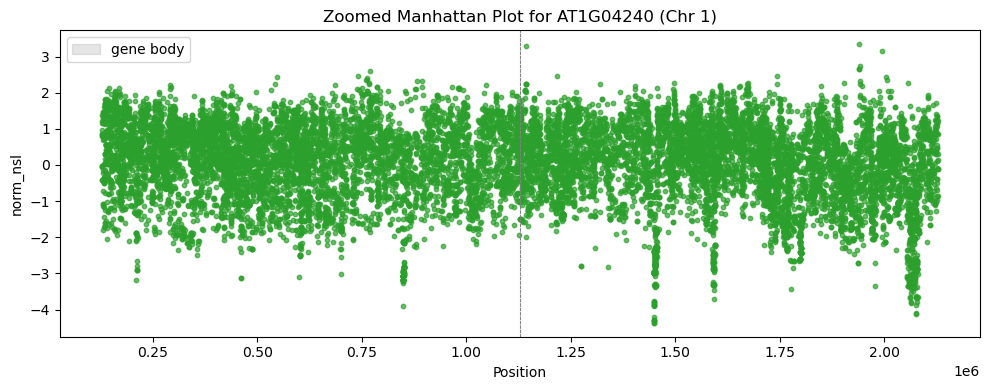

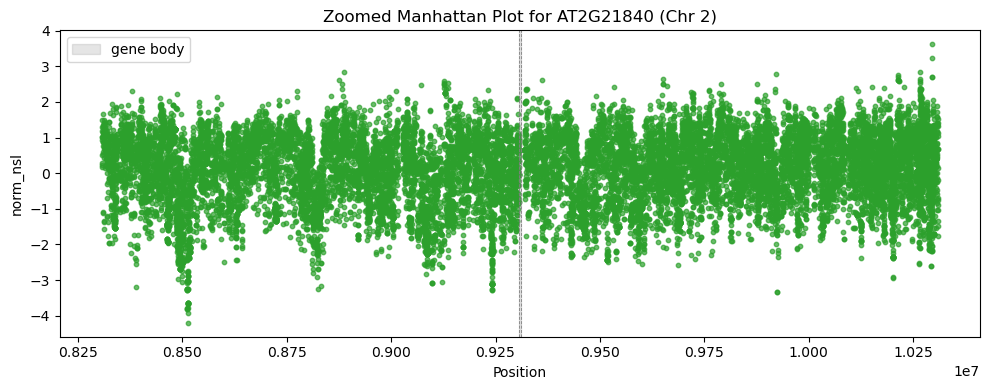

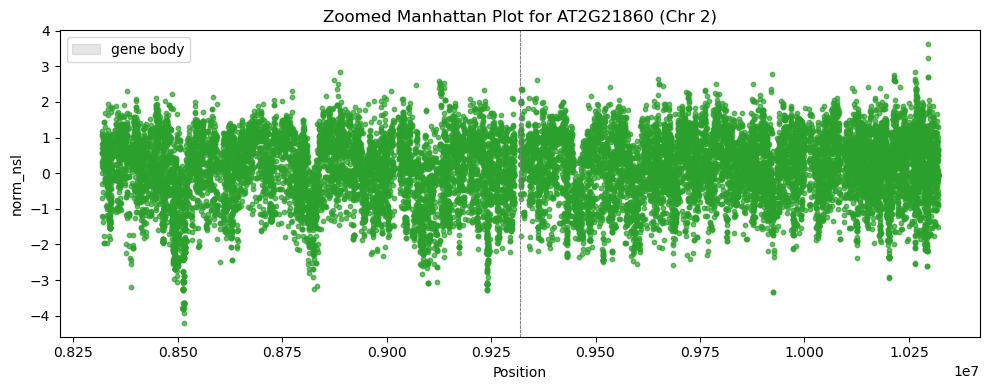

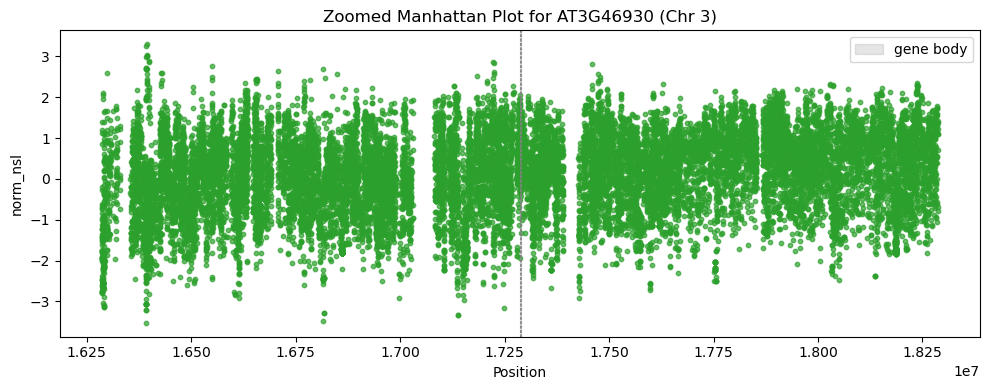

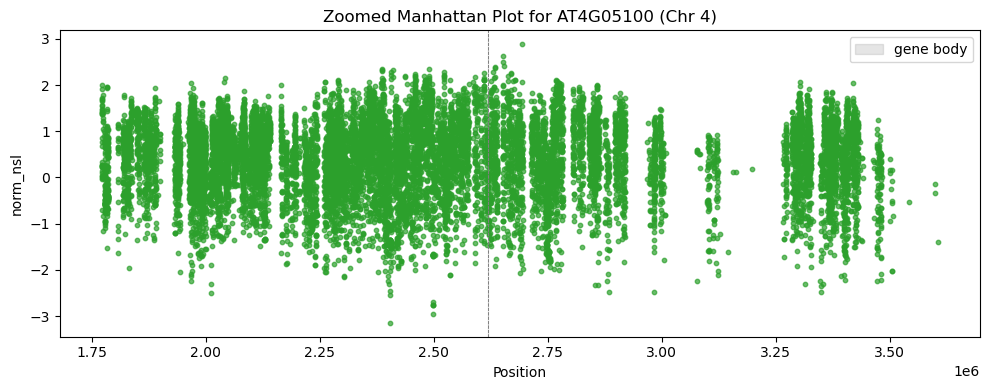

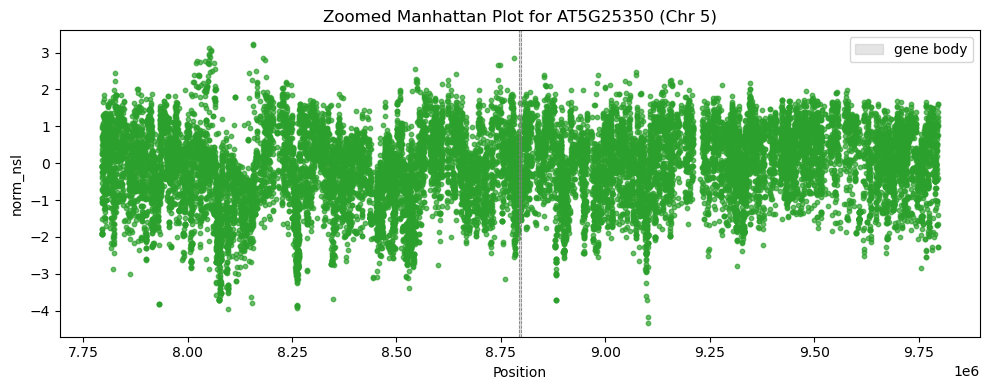

In [45]:
import matplotlib.pyplot as plt

for _, row in gene_df.iterrows():
    chrom = row['chrom']
    gene_start = row['start']
    gene_end = row['end']
    gene_id = row['gene_id']
    
    # Filter region: ±5kb around gene
    region_df = df[(df['chrom'] == chrom) & (df['pos'] >= gene_start - 1000000) & (df['pos'] <= gene_end + 1000000)]

    if region_df.empty:
        continue  # Skip if no data in region

    plt.figure(figsize=(10, 4))

    # Manhattan-style scatter
    plt.scatter(region_df['pos'], region_df['norm_nsl'], s=10, alpha=0.7, color='#2ca02c')
    
    # Gene region highlight
    plt.axvspan(gene_start, gene_end, color='grey', alpha=0.2, label='gene body')
    plt.axvline(gene_start, color='grey', linestyle='--', linewidth=0.6)
    plt.axvline(gene_end, color='grey', linestyle='--', linewidth=0.6)

    # Plot labels
    plt.title(f'Zoomed Manhattan Plot for {gene_id} (Chr {chrom})')
    plt.xlabel('Position')
    plt.ylabel('norm_nsl')
    plt.legend()
    plt.tight_layout()
    plt.show()
